# アニメの情報からカテゴリを予測する

予測するのに使う情報
- タイトル
- 説明

In [269]:
# GPUが使える場合は使う
import torch 

if torch.cuda.is_available():
    d_type = "cuda:0"
else:
    d_type = "cpu"

device = torch.device(d_type)




データの準備
==================

Kaggleにデータがあったので、以下のコマンドでダウンロードする
```bash
kaggle datasets download -d dbdmobile/myanimelist-dataset
```


In [270]:
%matplotlib inline

In [271]:
# カレントディレクトリにmyanimelist-dataset.zipがない場合はダウンロード
![ ! -f ./myanimelist-dataset.zip] && kaggle datasets download -d dbdmobile/myanimelist-dataset

/bin/bash: 0 行: [: `]'がありません


In [272]:
!ls # ダウンロードしたファイルがあるかどうか確認

20240710_勉強会_RNN_演習.ipynb		  all_losses.pth	   rnn.pth
20240710_勉強会_RNN_演習_人名2性別.ipynb  data			   tutuorial
__init__.py				  myanimelist-dataset.zip


In [273]:
# ダウンロードしたデータを解答
import zipfile
import os
from pathlib import Path


DATASET_PATH = "data"

# すでにデータセットを格納するディレクトリがあるかどうか確認
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)

# データを解凍
if not os.path.exists(Path(DATASET_PATH, "anime-dataset-2023.csv").resolve()):
  with zipfile.ZipFile('myanimelist-dataset.zip', 'r') as zip_ref:
      zip_ref.extractall(DATASET_PATH)

In [274]:
# データセットのファイル名を確認
!ls data

anime-dataset-2023.csv	final_animedataset.csv	users-details-2023.csv
anime-filtered.csv	user-filtered.csv	users-score-2023.csv


In [275]:
# データを読み込む
import pandas as pd
from pathlib import Path

anime = pd.read_csv(Path(DATASET_PATH, "anime-dataset-2023.csv").resolve())
anime.dropna()
# データを表示
anime.head()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


In [276]:
import random


def random_index(list_length):
    return random.randint(0, list_length - 1)

In [277]:
# 学習に使う列
LEARN_COLUMN = "English name"
# データを整形する
anime = anime[[LEARN_COLUMN, "Genres"]]

# ジャンルを最初の１つだけにする
anime["Genres"] = anime["Genres"].apply(
    lambda x: x.split(", ")[random_index(len(x.split(", ")))]
)

# UNKNWONが含まれるカラムを表示
anime[anime["Genres"].str.contains("UNKNOWN")]

# LEARN_COLUMNに UNKNOWNを含む行を削除
anime = anime[~anime[LEARN_COLUMN].str.contains("UNKNOWN")]
print(anime.isnull().any())
anime.head()

English name    False
Genres          False
dtype: bool


,English name,Genres
0,Cowboy Bebop,Action
1,Cowboy Bebop: The Movie,Action
2,Trigun,Sci-Fi
3,Witch Hunter Robin,Mystery
4,Beet the Vandel Buster,Supernatural


In [278]:
# データの数などの情報を取得
genres_list = list(anime.Genres.str.split(", ").explode().unique())
print(f"genres_list = {genres_list}")

n_genres = len(genres_list)
print(f"n_genres = {n_genres}")

genres_list = ['Action', 'Sci-Fi', 'Mystery', 'Supernatural', 'Romance', 'Drama', 'Adventure', 'Sports', 'Gourmet', 'Fantasy', 'Comedy', 'Slice of Life', 'Ecchi', 'Award Winning', 'Suspense', 'Horror', 'Hentai', 'Girls Love', 'UNKNOWN', 'Avant Garde', 'Erotica', 'Boys Love']
n_genres = 22


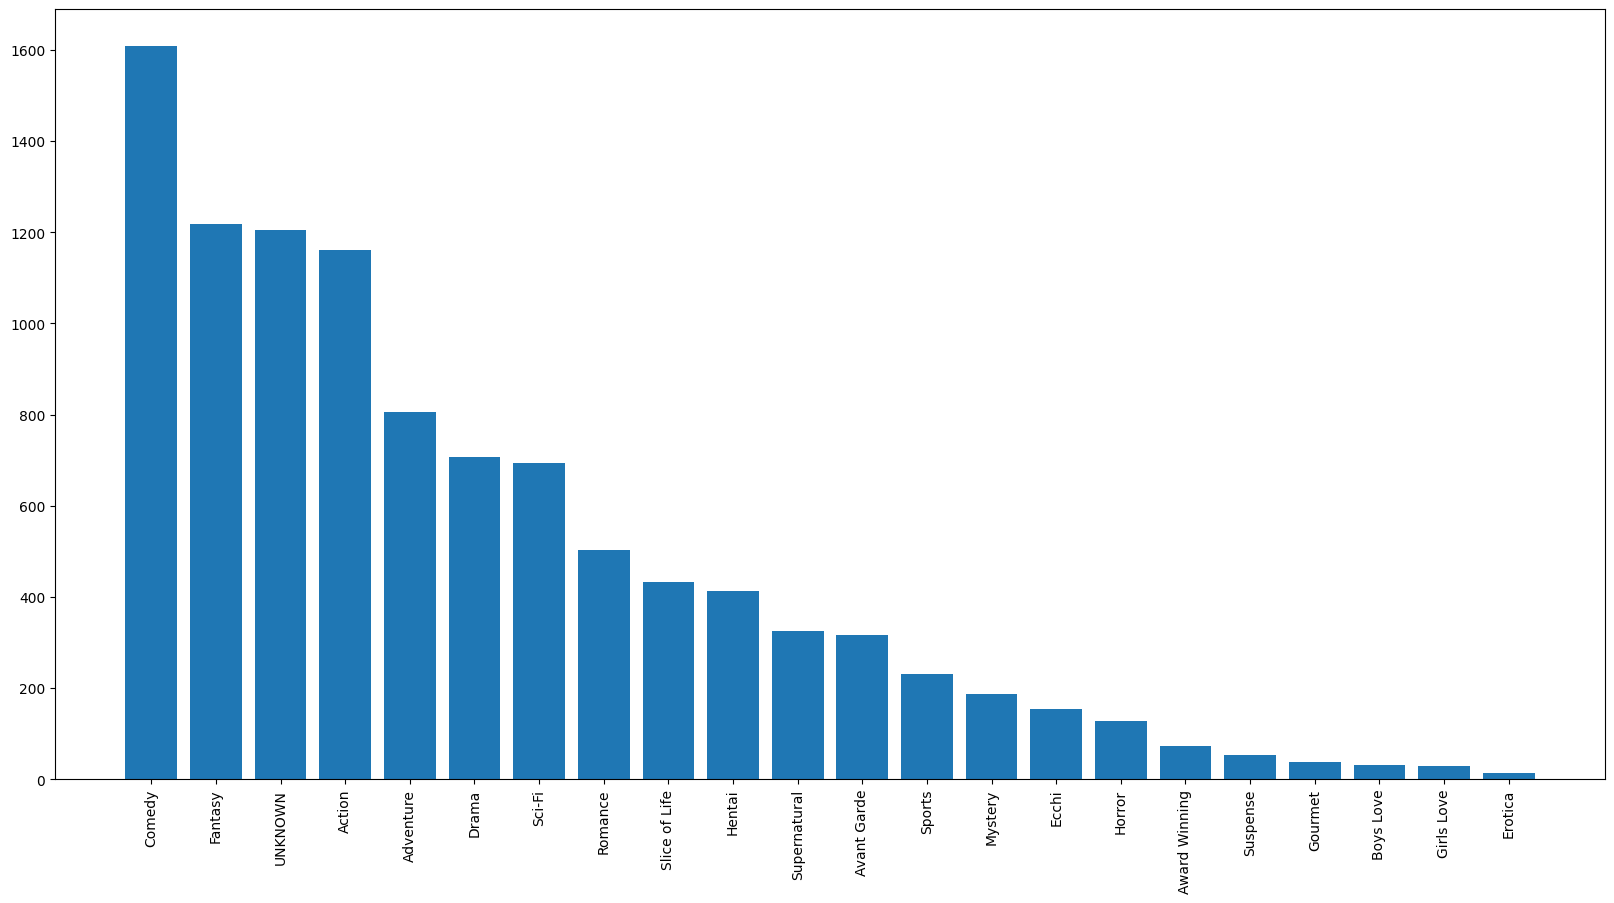

In [279]:
import matplotlib.pyplot as plt

genre_dict = {name : 0 for name in genres_list}
for genre in genres_list:
    genre_dict[genre] = anime.Genres.str.contains(genre).astype(int).sum()

# genre_dictを多い順にソートしたtuple
sorted_genre_dict = sorted(genre_dict.items(), key=lambda x: x[1], reverse=True)
# genre_dictをプロットする

plt.figure(figsize=(20, 10))
plt.bar(range(n_genres), [genre[1] for genre in sorted_genre_dict])
plt.xticks(range(n_genres), [genre[0] for genre in sorted_genre_dict], rotation=90)
plt.show()


タイトルデータのテンソルへの変換
--------------------------

学習に使えるようにするため、タイトルデータをテンソルに変換します。





一つの文字は、`<1 x n_letters>`サイズの、 "ワンホットベクトル "を使って表現されます。

ワンホットベクトルは、表現したい文字のインデックス（=位置）にのみ1が格納され、それ以外のインデックス（＝位置）は0で埋められたベクトルです。

例えば、"b"という文字であれば、`"b" =<0 1 0 0 0 ...>`という形で表現します。

（日本語訳注 ："b"は、ローマ字では二番目の文字であるため、二番目のみ1でそれ以外は0のベクトルで表現されます。"c"なら、ローマ字の3番目なので、`"c" =<0 0 1 0 0 ...>`という形式で表現されます。）





単語を作るためには、これらを2次元の行列 `<line_length x 1 x n_letters>` に結合します。

（日本語訳注 ：例えば、"abc"という単語であれば、
`"abc" =<1 0 0 0 0 ...>, <0 1 0 0 0 ...>, <0 0 1 0 0 ...>`のように表現されるイメージです。）

<br>

`line_length`と`n_letters`の間にある余分に見える1次元は、バッチサイズです。

この次元は、PyTorchではデータをすべてバッチとして処理する仕様のため、必要となります。

ここでは、バッチサイズは1としています。

In [280]:
import string
import torch

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters).to(device)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters).to(device)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

print(anime[LEARN_COLUMN][0])
print(lineToTensor(anime[LEARN_COLUMN][0]).size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0')
torch.Size([5, 1, 57])
Cowboy Bebop
torch.Size([12, 1, 57])


## ネットワークの訓練

In [281]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1).to(device)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).to(device)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_genres).to(device)

訓練
========
ヘルパー関数の定義

In [282]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return genres_list[category_i], category_i


また、訓練用にデータの具体例（苗字とその言語）を簡単に取得して、提示する関数もあると便利です。

In [283]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    genre = randomChoice(genres_list)
    anime_titles = anime[anime['Genres'].str.contains(genre, case=False)][LEARN_COLUMN]

    line = randomChoice(anime_titles.to_list())
    genre_tensor = torch.tensor(genres_list.index(genre), dtype=torch.long).to(device)
    line_tensor = lineToTensor(line).to(device)
    return genre, line, genre_tensor, line_tensor


for i in range(10):
    genre, line, genre_tensor, line_tensor = randomTrainingExample()
    print('genre =', genre, '/ line =', line)
    print(genre_tensor)
    print(line_tensor.size())


genre = Mystery / line = Ron Kamonohashi: Deranged Detective
tensor(2, device='cuda:0')
torch.Size([35, 1, 57])
genre = Supernatural / line = Shaolin Wuzang
tensor(3, device='cuda:0')
torch.Size([14, 1, 57])
genre = Romance / line = The Girl Downstairs
tensor(4, device='cuda:0')
torch.Size([19, 1, 57])
genre = Suspense / line = Shadow Star Narutaru
tensor(14, device='cuda:0')
torch.Size([20, 1, 57])
genre = Fantasy / line = Dragon Ball GT
tensor(9, device='cuda:0')
torch.Size([14, 1, 57])
genre = Hentai / line = Nightmare Campus
tensor(16, device='cuda:0')
torch.Size([16, 1, 57])
genre = Horror / line = Angels of Death
tensor(15, device='cuda:0')
torch.Size([15, 1, 57])
genre = Supernatural / line = The Infinitors
tensor(3, device='cuda:0')
torch.Size([14, 1, 57])
genre = UNKNOWN / line = Grass Elf
tensor(18, device='cuda:0')
torch.Size([9, 1, 57])
genre = Romance / line = Tsubasa RESERVoir CHRoNiCLE Season Two
tensor(4, device='cuda:0')
torch.Size([38, 1, 57])


ネットワークの訓練
----------------------

このネットワークの訓練に必要なプロセスは、多くの正解付きデータ（アノテーション付きの教師データ）を入力して推論させ、推論結果の良否をフィードバックすることです。

RNNの最後の層は`nn.LogSoftmax`なので、対応する損失関数は`nn.NLLLoss`となります。

In [284]:
criterion = nn.NLLLoss()

In [285]:
import torch.optim as optim
from torch.nn.parameter import Parameter


learning_rate = (
    0.001  # If you set this too high, it might explode. If too low, it might not learn
)

# オプティマイザを定義（例：SGDオプティマイザ）
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)

# オプティマイザを定義（例：SGDオプティマイザ）


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    category_tensor = (
        category_tensor.view(1).type(torch.LongTensor).to(device)
    )  # バッチサイズ1の整数型テンソルに変換

    loss = criterion(output, category_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=5.0)  # max_normの値を調整

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     if p is None:
    #         continue
    #     elif not isinstance(p.data, Parameter):
    #         continue
    #     else:
    #         p.data.add_(p.grad.data, alpha=-learning_rate)
    # 勾配がNoneでないことを確認するデバッグ出力
    # for p in rnn.parameters():
    #     if p.grad is None:
    #         print(f"Parameter {p} has no gradient.")
    #     else:
    #         print(f"Parameter {p} gradient size: {p.grad.size()}")

    # オプティマイザでパラメータを更新する
    optimizer.step()

    return output, loss.item()

In [286]:
import torch
import time
import math
import numpy as np

# テスト用
# n_iters = 1000
# print_every = 100
# plot_every = 100
n_iters = 500000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


start = time.time()


def check_gradient_explosion(model, threshold=1e2):
    total_norm = 0
    for param in model.parameters():
        if param.grad is not None:
            grad_norm = param.grad.data.norm(2).item()
            total_norm += grad_norm ** 2
            if grad_norm > threshold:
                return True, grad_norm, total_norm
    return False, None, total_norm


def train_model(retrain=False):
    current_loss = 0
    all_losses = []

    # 訓練済みのモデルがあればそれを返す
    if os.path.exists("rnn.pth") and not retrain:
        print("model exists")
        # モデルを保存
        model = RNN(n_letters, n_hidden, n_genres).to(device)
        model.load_state_dict(torch.load("rnn.pth"))

        # all_lossesを保存
        all_losses = torch.load("all_losses.pth")
        return model, all_losses
    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()

        output, loss = train(category_tensor, line_tensor)
        current_loss += loss

        # 勾配爆発のチェック
        exploded, grad_norm, total_norm = check_gradient_explosion(rnn)
        if exploded:
            print(
                f"Gradient explosion detected at epoch {iter}, gradient norm: {grad_norm}"
            )
            break


        if np.isnan(loss):
            print("Loss is NaN.涙涙涙涙。。。。")
            print(f"category = {category}")
            print(f"line = {line}")
            print(f"category_tensor = {category_tensor}")
            print(f"line_tensor = {line_tensor}")
            raise ValueError("Loss is NaN.涙涙涙涙。。。。")

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = "✓" if guess == category else "✗ (%s)" % category
            average_loss = current_loss / plot_every
            print(
                f"{iter} {iter / n_iters * 100}% ({timeSince(start)}) norm: {total_norm} | {average_loss:.4f} {line} / {guess} {correct}"
            )

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    # 作成したモデルを保存
    torch.save(rnn.state_dict(), "rnn.pth")
    # all_lossesを保存
    torch.save(all_losses, "all_losses.pth")
    return rnn, all_losses


trained_rnn, all_losses = train_model(retrain=True)

5000 1.0% (0m 54s) norm: 3.2125163211606846 | 3.0867 My Life as Inukai-san’s Dog. OVA / Girls Love ✗ (Comedy)
10000 2.0% (1m 47s) norm: 3.008225490530471 | 3.0810 Banana Fish / Slice of Life ✗ (Suspense)
15000 3.0% (2m 40s) norm: 3.3174026055375343 | 3.0782 One Piece: Recapping Fierce Fights! Zoro vs. a Lead Performer! / Boys Love ✗ (Action)
20000 4.0% (3m 33s) norm: 3.3458044167928946 | 3.0719 If My Favorite Pop Idol Made It to the Budokan, I Would Die / Erotica ✗ (Girls Love)
25000 5.0% (4m 25s) norm: 3.225526451049408 | 3.0677 DIVE!! / Comedy ✗ (Sports)
30000 6.0% (5m 21s) norm: 3.279553070828136 | 3.0646 Dream / Avant Garde ✗ (Award Winning)
35000 7.000000000000001% (6m 16s) norm: 3.2525199915656096 | 3.0624 Martian Successor Nadesico: The Prince of Darkness / Hentai ✗ (Award Winning)
40000 8.0% (7m 12s) norm: 3.152393253437797 | 3.0476 I'm Joybo 2nd Season / Horror ✗ (Drama)
45000 9.0% (8m 8s) norm: 3.58733785675674 | 3.0501 The Island of Giant Insects Movie / Erotica ✗ (Horror)
5

結果のプロット
--------------------

`all_losses`から過去の損失をプロットすると、ネットワーク学習の様子がわかります

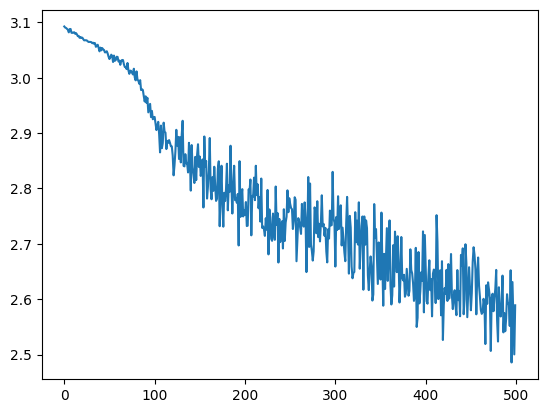

In [287]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

結果の評価
======================

ネットワークが各カテゴリ（言語）に対して、どの程度の性能を発揮しているのかを確認するために、実際の言語（=行）ごとに、ネットワークの推論結果がどの言語だったのか（列）を示す、混同行列（confusion matrix）を作成します。

混同行列を計算するために、`evaluate()`関数を用いて多くのサンプルを入力としてネットワークを実行しますが、この`evaluate()`関数は、逆伝播を実行しない`train()`関数と同義です。


In [288]:
import numpy as np
# バージョン
print(np.__version__)

1.26.4


/tmp/ipykernel_17784/766758957.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + genres_list, rotation=90)
/tmp/ipykernel_17784/766758957.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + genres_list)


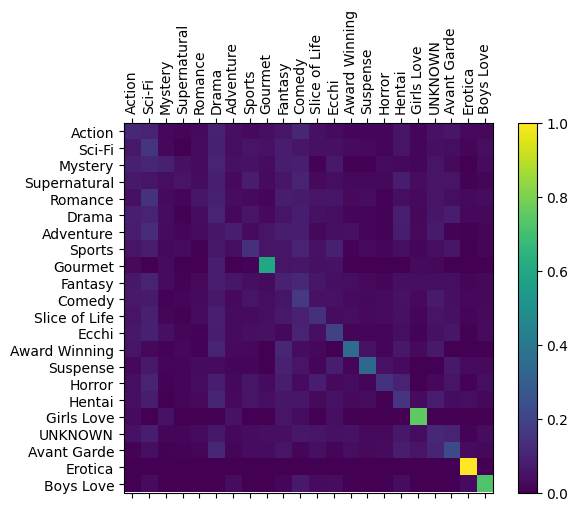

In [289]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_genres, n_genres).to(device)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = trained_rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = trained_rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = genres_list.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_genres):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.cpu().numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + genres_list, rotation=90)
ax.set_yticklabels([''] + genres_list)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

斜めの軸の点の明るさから、どの言語で推測結果に間違いが多いか分かります

（日本語訳注：点が暗いほどその言語に対する予測結果は間違いが多く、明るいほど正解が多いことを示しています）。

例えば、ギリシャ語では非常に良く、英語では非常に悪いようです（これはおそらく、英語の苗字は他の言語との重複が多いためでしょう）。

ユーザーが入力した苗字に対する推論実行
---------------------




In [290]:
def predict(input_line, n_predictions=3):
    print("\n> %s" % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print("(%.2f) %s" % (value, genres_list[category_index]))
            predictions.append([value, genres_list[category_index]])

In [295]:
# 日本語訳追記：[1] 上記の結果は実行の度に変わります。[2] 今回は検証のデータセットを用意していないので、過学習する恐れがあります。

# 田中で試す
predict("Alice in Wonderland")
predict("Hero")


> Alice in Wonderland
(-2.25) Sports
(-2.32) Suspense
(-2.33) Fantasy

> Hero
(-1.89) UNKNOWN
(-1.93) Avant Garde
(-2.40) Horror
